# EDA on Events & Sessions data

## Testing db connection & reading in data

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.pylabtools import figsize
import scipy.stats as stats

In [3]:
conn = psycopg2.connect(dbname='ml2usfdb', user='ml2usf', password='weisanbri', 
                        host='ml2dbinstance.cnvuzu0uiiq9.us-west-2.rds.amazonaws.com', port='5432')

In [4]:
conn

<connection object at 0x10e094420; dsn: 'user=ml2usf password=xxx dbname=ml2usfdb host=ml2dbinstance.cnvuzu0uiiq9.us-west-2.rds.amazonaws.com port=5432', closed: 0>

In [ ]:
# pd.read_sql('select * from sessions where is_mau != true and is_wau != true;', conn)
# events_df = pd.read_sql('select * from events where event == 8', conn)

In [6]:
# events_types = {'app_id': np.uint32, 'session_id': np.uint64, 'event': np.unicode_,
#                 'event_timestamp': np.uint64, 'event_value': np.float16, 'user_id_hash': np.unicode_
#                }

# events_df = pd.read_pickle('events_df.pkl')
# events_df = pd.read_csv('./events.csv', usecols=events_types.keys(), dtype=events_types)

In [ ]:
events_df = pd.read_csv('../events/events.csv')

In [ ]:
events_df.head()

In [ ]:
events_df.info(memory_usage='deep')

In [ ]:
sessions_types = {'app_id': np.uint64, 'session_id': np.uint64, 'start_timestamp': np.uint32, 'timezone': 'category', 
                  'previous_sessions_duration': np.uint32, 'timezone_offset': np.float64,
                  'user_created_timestamp': np.uint64, 'is_user_first_session': 'category', 
                  'is_session': 'category', 'is_developer': 'category', 'is_wau': 'category', 'is_mau': 'category',
                  'country': 'category', 'city': 'category', 'os_name': 'category',
                  'session_index': np.uint32, 'user_id_hash': np.unicode_
                 }

sessions_df = pd.read_csv('../sessions/sessions.csv', usecols=sessions_types.keys(), dtype=sessions_types)

In [ ]:
sessions_df.info(memory_usage='deep')

In [ ]:
sessions_df.head()

In [ ]:
sessions_df = sessions_df.loc[(sessions_df['is_wau'] == 'false') & 
                              (sessions_df['is_mau'] == 'false') & 
                              (sessions_df['is_developer'] == 'false')]

In [16]:
# events_df.to_pickle('events_df.pkl')
# sessions_df.to_pickle('sessions_df.pkl')

In [86]:
# events_df = pd.read_pickle('events_df.pkl')
sessions_df = pd.read_pickle('sessions_df.pkl')

In [87]:
sessions_df.head()

,app_id,session_id,start_timestamp,timezone,previous_sessions_duration,user_created_timestamp,is_user_first_session,is_session,is_developer,is_wau,is_mau,country,city,os_name,session_index,user_id_hash
0,4724682771660800,5558845121177764917,322105316,Asia/Manila,25837591,1538874289458,false,true,false,false,false,PH,makati,Android OS,30,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,4724682771660800,2201961907282901522,1819718029,Asia/Manila,35050130,1538874289458,false,true,false,false,false,PH,quezon city,Android OS,47,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,4724682771660800,18781111175537580,1617276698,Asia/Manila,11343848,1538874289458,false,true,false,false,false,PH,makati,Android OS,10,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,4724682771660800,1477540082628742048,2522451042,Asia/Manila,13499724,1538874289458,false,true,false,false,false,PH,davao city,Android OS,13,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,4724682771660800,8184875317380844086,778366264,Asia/Manila,32788010,1538874289458,false,true,false,false,false,PH,makati,Android OS,41,9943447915df3a45fd6720a026af905b6da6b56a37701b...


# Data Visualization & EDA

### Basic Info - number of sessions

Total number of unique users

In [21]:
len(sessions_df['user_id_hash'].unique())

620799

Average number of unique sessions for all users

In [42]:
np.mean(sessions_df['user_id_hash'].value_counts().tolist())

10.047129586226783

This average number doesn't tell the full story though.

Quanitiles of number of unique sessions for all users 

In [43]:
s = pd.Series(sessions_df['user_id_hash'].value_counts().tolist())

In [47]:
s.quantile([.05, .25, .5, .75, 0.90, 0.95, 0.99])

0.05      1.0
0.25      2.0
0.50      3.0
0.75      6.0
0.90     20.0
0.95     43.0
0.99    131.0
dtype: float64

As shown above, there are many, many users that only use the app a few times. This isn't even accounting for the sessions that may just be a push notification.

Accounting for push notifications:

In [59]:
real_sesh = sessions_df.loc[sessions_df['is_session']=='true']

In [60]:
s2 = pd.Series(real_sesh['user_id_hash'].value_counts().tolist())
s2.quantile([.05, .25, .5, .75, 0.90, 0.95, 0.99])

0.05      1.0
0.25      1.0
0.50      2.0
0.75      5.0
0.90     18.0
0.95     38.0
0.99    111.0
dtype: float64

Again, it looks like most users only have a few sessions each.

Percent of sessions that are the first session of a user

In [51]:
n = len(sessions_df)
n

6237248

In [57]:
sessions_df.groupby('is_user_first_session')['session_id'].count()

is_user_first_session
false    5388758
true      848490
Name: session_id, dtype: int64

In [58]:
(848490/n)*100

13.603595688354863

13% of all the sessions are first sessions, so this corroborates the idea that many users do not use the app multiple times.

In [ ]:
sessions_df.groupby('user_id_hash')['previous_sessions_duration'].mean()

In [67]:
sessions_df['session_index'].max()

1404

Histogram of session index where the index is < 40

In [106]:
sesh_index = sessions_df.groupby('session_index')['session_index'].count()

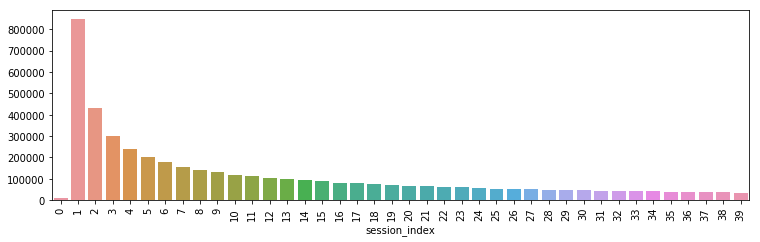

In [111]:
figsize(12.5, 3.5)
ax = sns.barplot(sesh_index.index[0:40], sesh_index.values[0:40])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Location & phone info

Most sessions occured in these 20 cities

In [62]:
city_freq = sessions_df.groupby('city')['session_id'].count()

In [66]:
city_freq.sort_values(ascending=False)[:20]

city
london          97401
chicago         94506
new york        82615
quezon city     79958
atlanta         77111
dallas          73378
kuala lumpur    58304
los angeles     57964
houston         57592
lagos           50290
bengaluru       48556
mumbai          48122
washington      47153
?               46479
jakarta         46125
makati          41634
delhi           41355
pune            39759
sydney          38953
singapore       38602
Name: session_id, dtype: int64

Most sessions occurred in these 20 countries

In [68]:
country_freq = sessions_df.groupby('country')['session_id'].count()
country_freq.sort_values(ascending=False)[:20]

country
US    2805848
IN     494784
GB     443411
PH     259492
CA     188399
ZA     164678
AU     148261
ID     102456
MY      87667
DE      73529
BR      72176
NG      58751
NL      54020
PK      45357
PL      41758
SG      38630
NZ      37332
EG      35296
RO      34369
BD      33983
Name: session_id, dtype: int64

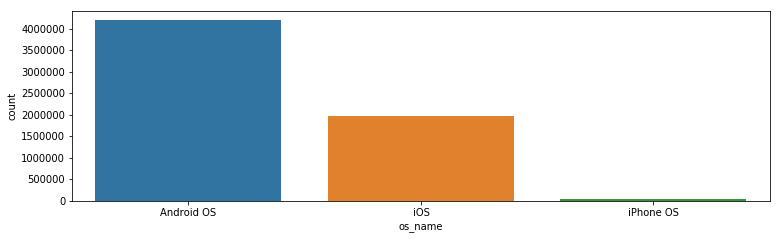

In [113]:
figsize(12.5, 3.5)
ax = sns.countplot(x='os_name', data=sessions_df)
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

Within US, the OS breakdown is as shows:

In [17]:
us = sessions_df.loc[sessions_df['country']=='US']

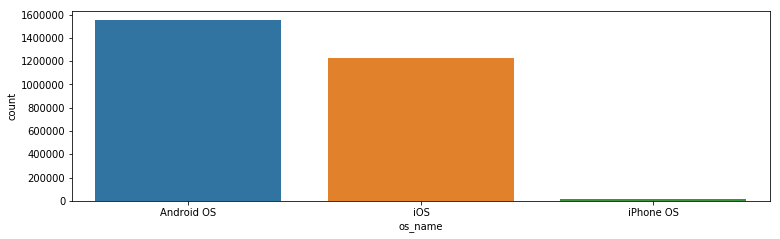

In [18]:
figsize(12.5, 3.5)
ax = sns.countplot(x='os_name', data=us)
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

### Date/time info

In [88]:
sessions_df['user_created_timestamp'] = pd.to_datetime(sessions_df['user_created_timestamp'], unit='ms')
sessions_df['stime'] = pd.to_datetime(sessions_df['start_timestamp'], unit='ms')

Histogram of number of days used since user was created

In [76]:
df_used_days = sessions_df[['user_created_timestamp', "user_id_hash"]].groupby(["user_id_hash"]) \
                                                                .agg({"user_created_timestamp":"min"}).reset_index()
df_used_days["used_days"] = pd.to_datetime('2018-12-08')
df_used_days["used_days"] = (df_used_days["used_days"] - df_used_days["user_created_timestamp"]).dt.days
df_used_days = df_used_days.iloc[:, [0,2]]

In [100]:
df_used_days[0:20]

,user_id_hash,used_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,27
1,000059859ec188af6035870faf885c3038cedda05b3a54...,15
2,000062e9be78f3da274fec338e78f89d12000e781967f2...,61
3,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,50
4,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,15
5,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,15
6,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,11
7,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,39
8,0000c91fb9908357cc11974d0fc67a260ddb46508055f2...,50
9,0000e2a3c14887640e2ccf2902b23e6b627856fab9efd6...,26


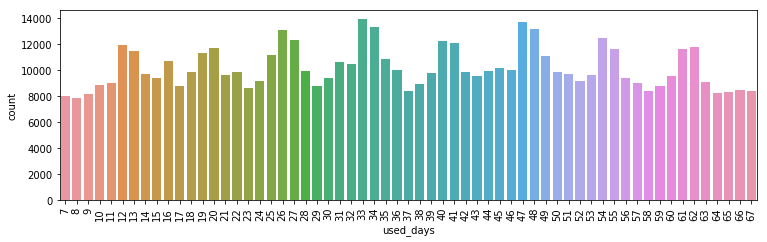

In [102]:
figsize(12.5, 3.5)
ax = sns.countplot(x='used_days', data=df_used_days)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

As the plot of the above shows, this is definitely time series data

Now examining the events data

In [21]:
purchases = events_df.loc[events_df['event'] == '8']
purchases['event_timestamp'] = pd.to_datetime(purchases['event_timestamp'], unit='ms')
purchases.head()

,app_id,session_id,event,event_timestamp,event_value,user_id_hash
279,4724682771660800,5159335150551901701,8,2018-11-11 05:03:20.211,3.493,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2898,4724682771660800,845986603555615931,8,2018-11-27 22:23:53.771,3.493,deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...
2970,4724682771660800,2846996524173831068,8,2018-11-24 01:38:59.172,3.493,deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...
3002,4724682771660800,6141788581998894012,8,2018-11-29 22:38:59.724,1.393,deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...
3597,4724682771660800,6974128812803113234,8,2018-11-05 16:57:37.644,1.393,b2ccdf1ae0d33e2e0a671d605f3fe4cdb72c7fc54bdd49...


In [22]:
purchases['date'] = purchases['event_timestamp'].dt.date

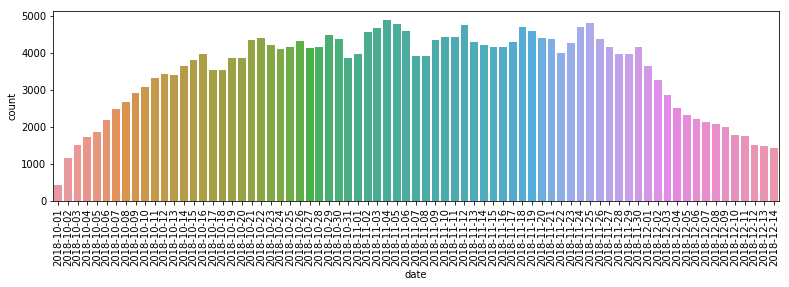

In [52]:
figsize(13, 3.5)
ax = sns.countplot(x='date', data=purchases)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The plot above shows the number of purchases that occured in the time period we are concered with. It looks like the number of purchases is higher in the middle period of time, and then it decrease towards the end.